# 影像辨識1

- ref: https://colab.research.google.com/drive/1MXd_gczN24Tbv7OZ77E7xeGGWs7Xcdr_?usp=sharing#scrollTo=c6tUTprCWdhH

- ref: https://colab.research.google.com/drive/1MXd_gczN24Tbv7OZ77E7xeGGWs7Xcdr_?usp=sharing#scrollTo=Fgg6dOfqid1i

### 安裝套件

In [1]:
!pip install matplotlib RedditReader Pillow torch torchvision wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ffd9cde0d2bffca29f30afd49143d86e5360e04d813b394b5b5194e90b726383
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# 引入套件
import numpy as np
import matplotlib.pyplot as plt
import torch
import wget
from PIL import Image
from RedditReader import Subreddit

### 取得reddit照片

In [3]:
def get_rand_meme():
    # Download a random meme from Reddit AnimalMemes.
    meme = Subreddit("AnimalMemes")
    meme.get_random()

    # Each meme contains an image URL.
    print(meme.url)

    # Download the image to the disk.
    image_filename = wget.download(meme.url)

    # Return the downloaded image file name.
    return image_filename

https://i.redd.it/ivdzbf4v8e591.jpg
ivdzbf4v8e591.jpg


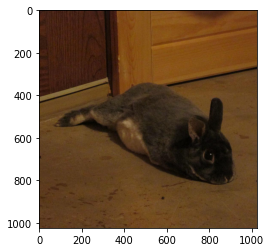

In [4]:
# 隨機下載，並顯示
image_filename =  get_rand_meme()
print(image_filename)

image = Image.open(image_filename).convert("RGB")
plt.imshow(image)

### 準備做辨識

#### 下載使用imagenet訓練好的模型

In [5]:
!wget https://raw.githubusercontent.com/maloyang/KH20220820_Python_ML_DL/main/W04/imagenet_labels.json -O imagenet_labels.json

--2022-09-16 21:20:42--  https://raw.githubusercontent.com/maloyang/KH20220820_Python_ML_DL/main/W04/imagenet_labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13473 (13K) [text/plain]
Saving to: ‘imagenet_labels.json’

imagenet_labels.jso 100%[===================>]  13.16K  --.-KB/s    in 0s      

2022-09-16 21:20:42 (75.7 MB/s) - ‘imagenet_labels.json’ saved [13473/13473]



In [6]:
# 看一下裡面有什麼, 總共有 1,000 個 label
import json

labels = json.load(open("imagenet_labels.json"))
print(len(labels), labels)

1000 ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondba

#### 載入模型
- 這裡直接使用 torchvision 所提供的由 ImageNet 訓練好的 ResNet-18 模型
- CPU版本進行

In [7]:
from torchvision import models

# Get the pre-trained ResNet-18 model.
model = models.resnet18(pretrained=True)

# Turn on evaluation mode (no training, inference only).
model.eval()

print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 由於模型的輸入必須要固定大小，因此定義了一個轉換的方法：將輸入的圖片轉成固定的大小後，再轉成 PyTorch 的資料格式（Tensor），並且根據 ImageNet 的 mean 與 standard deviation 做正規化。

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225],
    ),
])

這裡定義 function `run_classification()` 來實際做 inference。在將圖片餵給模型之前，除了要做上面提到的轉換，還要將格式從 `CHW` 轉成 `NCHW` 才會對。

In [9]:
def run_classification(model, transform, labels, image):
    # Apply transformation for the given image.
    input_image = transform(image)
    print(input_image.shape)
    # Convert format from CHW to NCHW.
    input_images = torch.unsqueeze(input_image, 0)
    print(input_images.shape)
    # Move image data from CPU to GPU.
    #input_images = input_images.cuda()

    # Do the inference.
    model_out = model(input_images)
    print(model_out.shape)

    # Get the label index that has largest probability.
    label_index = torch.argmax(model_out, 1)[0].item()
    # Get the label.
    label = labels[label_index]

    return label

再來是定義 function `is_dog()` 來根據模型輸出的 label 來判斷是否為狗。由於 ImageNet 的 label 並沒有直接定義是狗的 label，而是各種狗的種類。因此需要多一步來判斷是否為狗。

In [ ]:
# 原來列出來的dog type, 但有所不足
def is_dog(label):
    return label in [
        'dalmatian',
        'Mexican_hairless',
        'Newfoundland',
        'basenji',
        'Leonberg',
        'pug',
        'Great_Pyrenees',
        'Maltese_dog',
        'Old_English_sheepdog',
        'Shetland_sheepdog',
        'Greater_Swiss_Mountain_dog',
        'Bernese_mountain_dog',
        'French_bulldog',
        'Eskimo_dog',
        'African_hunting_dog',
        'Tibetan_terrier',
    ]

In [14]:
# 整理v2(相同類型的label大致有放在一起)
def is_dog(label):
  return label in [
"Chihuahua",
"Japanese_spaniel",
"Maltese_dog",
"Pekinese",
"Shih-Tzu",
"Blenheim_spaniel",
"papillon",
"toy_terrier",
"Rhodesian_ridgeback",
"Afghan_hound",
"basset",
"beagle",
"bloodhound",
"bluetick",
"black-and-tan_coonhound",
"Walker_hound",
"English_foxhound",
"redbone",
"borzoi",
"Irish_wolfhound",
"Italian_greyhound",
"whippet",
"Ibizan_hound",
"Norwegian_elkhound",
"otterhound",
"Saluki",
"Scottish_deerhound",
"Weimaraner",
"Staffordshire_bullterrier",
"American_Staffordshire_terrier",
"Bedlington_terrier",
"Border_terrier",
"Kerry_blue_terrier",
"Irish_terrier",
"Norfolk_terrier",
"Norwich_terrier",
"Yorkshire_terrier",
"wire-haired_fox_terrier",
"Lakeland_terrier",
"Sealyham_terrier",
"Airedale",
"cairn",
"Australian_terrier",
"Dandie_Dinmont",
"Boston_bull",
"miniature_schnauzer",
"giant_schnauzer",
"standard_schnauzer",
"Scotch_terrier",
"Tibetan_terrier",
"silky_terrier",
"soft-coated_wheaten_terrier",
"West_Highland_white_terrier",
"Lhasa",
"flat-coated_retriever",
"curly-coated_retriever",
"golden_retriever",
"Labrador_retriever",
"Chesapeake_Bay_retriever",
"German_short-haired_pointer",
"vizsla",
"English_setter",
"Irish_setter",
"Gordon_setter",
"Brittany_spaniel",
"clumber",
"English_springer",
"Welsh_springer_spaniel",
"cocker_spaniel",
"Sussex_spaniel",
"Irish_water_spaniel",
"kuvasz",
"schipperke",
"groenendael",
"malinois",
"briard",
"kelpie",
"komondor",
"Old_English_sheepdog",
"Shetland_sheepdog",
"collie",
"Border_collie",
"Bouvier_des_Flandres",
"Rottweiler",
"German_shepherd",
"Doberman",
"miniature_pinscher",
"Greater_Swiss_Mountain_dog",
"Bernese_mountain_dog",
"Appenzeller",
"EntleBucher",
"boxer",
"bull_mastiff",
"Tibetan_mastiff",
"French_bulldog",
"Great_Dane",
"Saint_Bernard",
"Eskimo_dog",
"malamute",
"Siberian_husky",
"dalmatian",
"affenpinscher",
"basenji",
"pug",
"Leonberg",
"Newfoundland",
"Great_Pyrenees",
"Samoyed",
"Pomeranian",
"chow",
"keeshond",
"Brabancon_griffon",
"Pembroke",
"Cardigan",
"toy_poodle",
"miniature_poodle",
"standard_poodle",
"Mexican_hairless",
"timber_wolf",
"white_wolf",
"red_wolf",
"coyote",
"dingo",
"dhole",
"African_hunting_dog",
    ]

以上都完成後，就可以真的跑模型看看結果囉。

### 把自己下載的圖片上傳到colab進行辨識

In [12]:
from google.colab import files

uploaded = files.upload()

Saving dog02.jpg to dog02.jpg


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
pug True


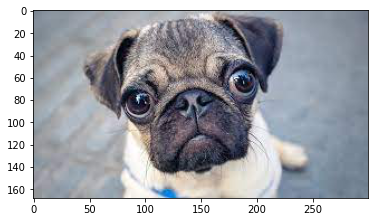

In [15]:
image = Image.open("dog02.jpg").convert("RGB")

label = run_classification(model, transform, labels, image)
print(label, is_dog(label))

plt.imshow(image)

#### 傳一張不是狗的照片試試看

In [16]:
from google.colab import files

uploaded = files.upload()

Saving cat02.jpg to cat02.jpg


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
Persian_cat False


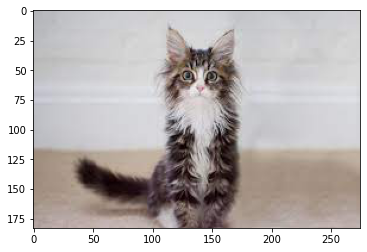

In [17]:
image = Image.open("cat02.jpg").convert("RGB")

label = run_classification(model, transform, labels, image)
print(label, is_dog(label))

plt.imshow(image)

### 來把reddit的圖片下載下來，並進行辨識

In [18]:
num_repeats = 40

dog_labels = []
dog_images = []
for _ in range(num_repeats):
    try:

      image_filename =  get_rand_meme()

      image = Image.open(image_filename).convert("RGB")
      label = run_classification(model, transform, labels, image)

      if is_dog(label):
          dog_labels.append(label)
          dog_images.append(image)
    except Exception as e:
        print(str(e))

print(dog_labels)

https://i.redd.it/g9gg31s97ic91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/wsxhdfvps8b91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/y82lz0lrx7m91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/y82lz0lrx7m91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/y82lz0lrx7m91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/zi0u0moerlg91.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/ivdzbf4v8e591.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/q9hfdi6v10f91.png
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
https://i.redd.it/hyvfm5fv17591.jpg
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch

In [19]:
print(dog_labels)

['German_shepherd', 'German_short-haired_pointer', 'golden_retriever', 'Staffordshire_bullterrier', 'dalmatian', 'Shih-Tzu', 'Chihuahua', 'flat-coated_retriever', 'standard_schnauzer', 'bull_mastiff']


### show出所有有狗的圖片

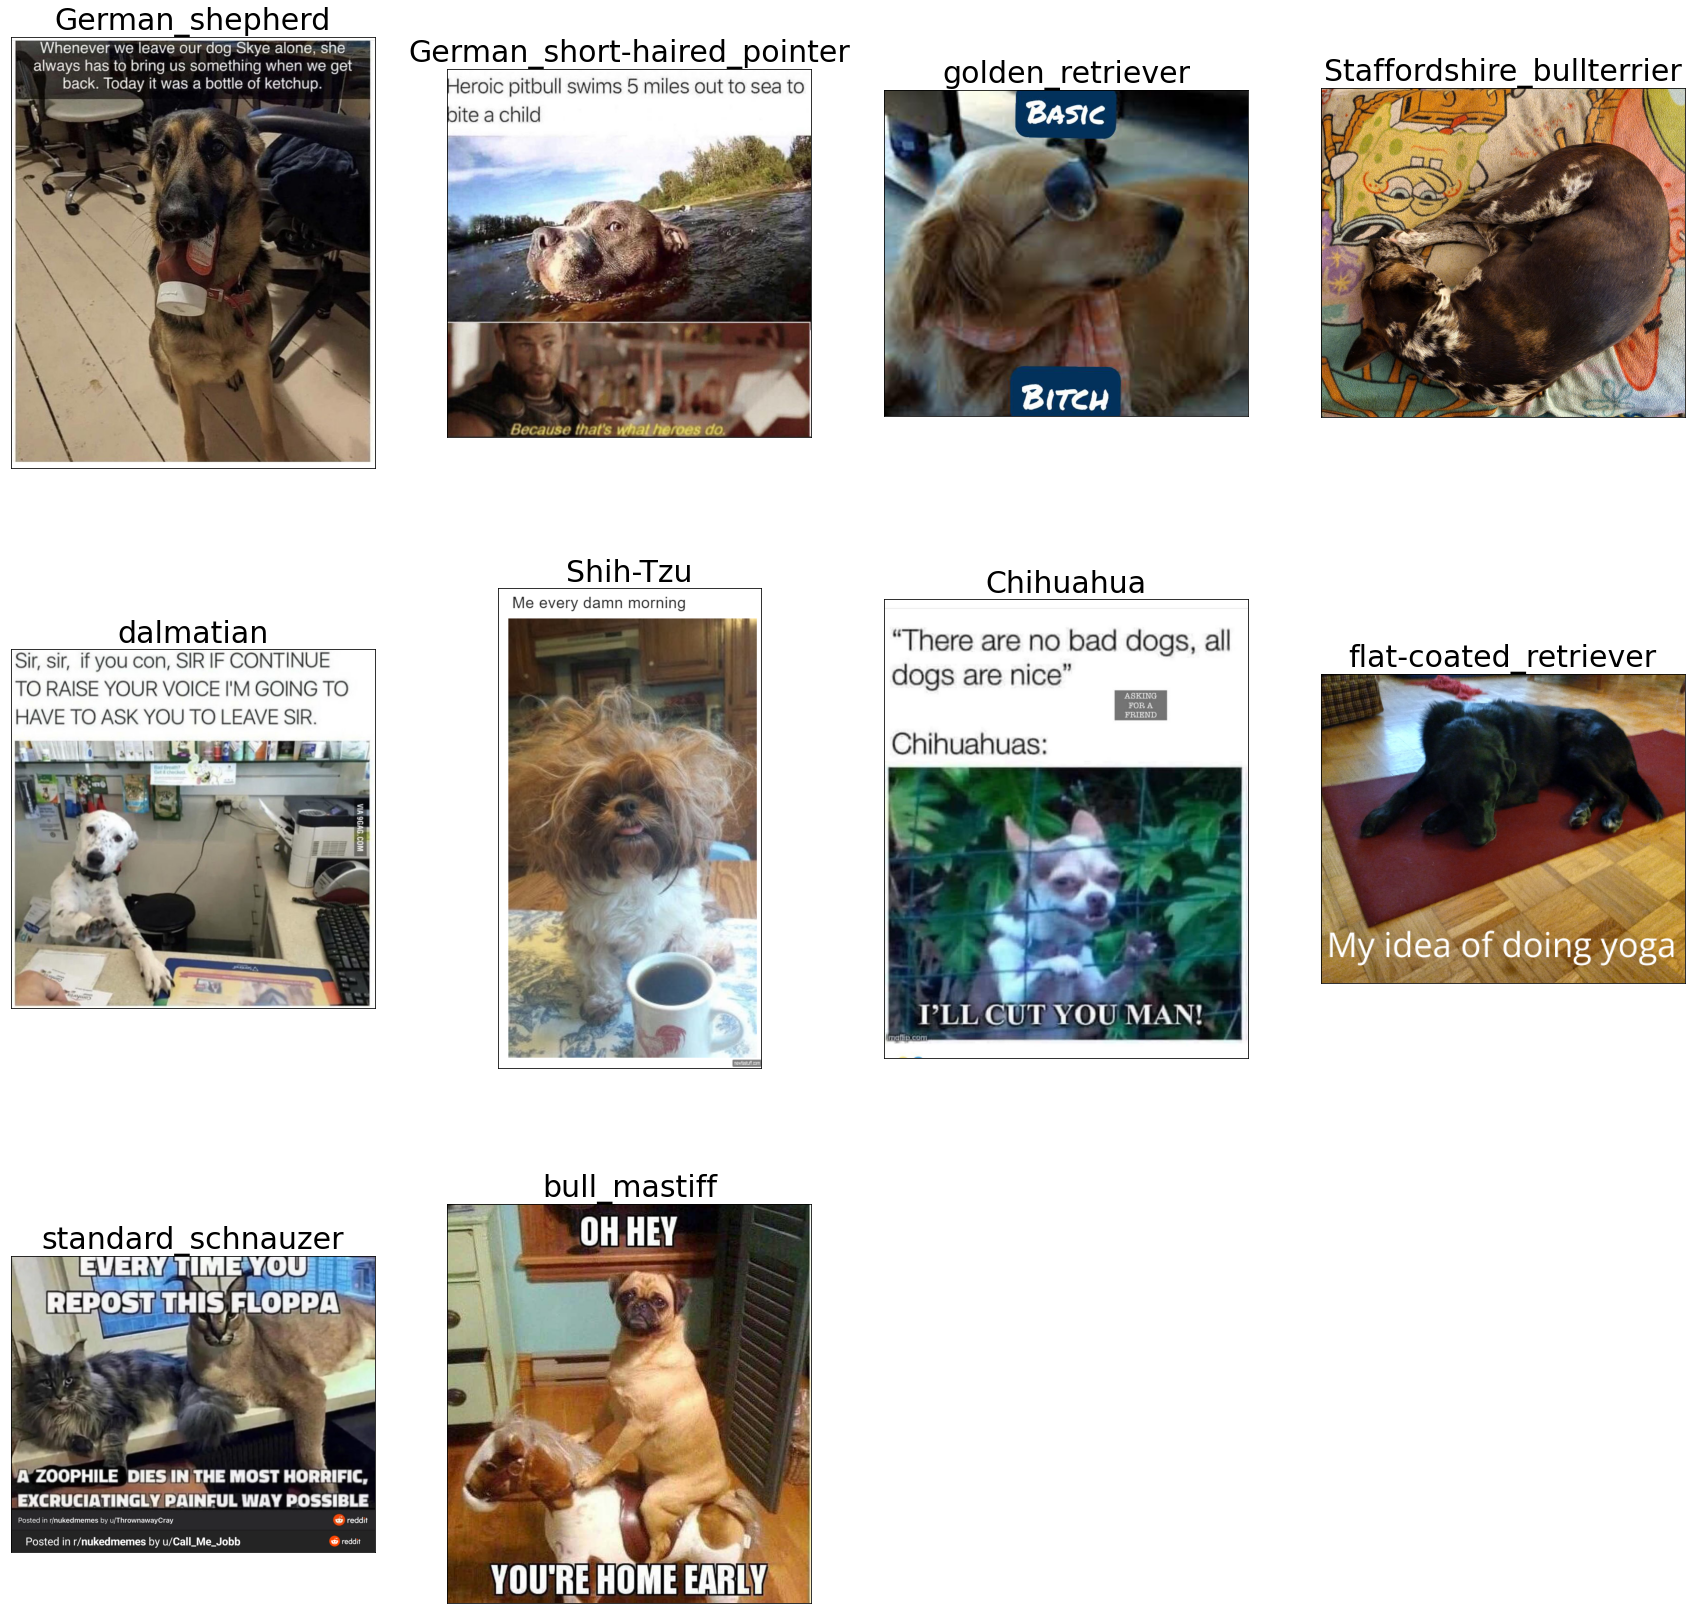

In [20]:
fig = plt.figure(figsize=(30, 30))
for idx in range(len(dog_labels)):
    ax = fig.add_subplot(
        int(len(dog_labels) / 4) + 1,
        4,
        idx + 1,
        xticks=[],
        yticks=[],
    )
    ax.imshow(dog_images[idx])
    ax.set_title(dog_labels[idx], size=30)

    fig.show()